In [396]:
import numpy as np

classA_data = np.loadtxt('classA_train.dat', delimiter='\t')
classB_data = np.loadtxt('classB_train.dat', delimiter='\t')
test_A=np.loadtxt('classA_test.dat', delimiter='\t')
test_B=np.loadtxt('classB_test.dat', delimiter='\t')
np.set_printoptions(precision=17, suppress=False)



#map to angles (angle encoding)
angles_A=classA_data -0.3
angles_B=classB_data -0.3

test_A=test_A -0.3 


#Define the Ry gate
def apply_Ry(state, theta):
    cos=np.cos(theta/2)
    sin=np.sin(theta/2)
    Ry=np.array([[cos, -sin], [sin, cos]], dtype=complex)
    new_state = np.dot(Ry, state)
    return new_state # / np.linalg.norm(new_state)
    
#define the CNOT gate
def apply_CNOT(control, target):
    combined_state = np.kron(control, target)
    CNOT = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ], dtype=complex)
    result = np.dot(CNOT, combined_state)
    #result = result / np.linalg.norm(result)
    return result.reshape(2,2)


#circuit design
def apply_Rx(state, theta):
    cos = np.cos(theta / 2)
    sin = np.sin(theta / 2)
    Rx = np.array([
        [cos, -1j * sin],
        [-1j * sin, cos]
    ], dtype=complex)
    new_state=np.dot(Rx, state)
    return new_state # / np.linalg.norm(new_state)

#circuit design



#ANGLE ENCODING 
def encode(angles):
    qubits=3
    final_states=[]
    
    #for each row of the data
    for angle in angles:
        #initialize qubits to |0>
        q_states=[np.array([1,0], dtype=complex) for _ in range(qubits)]
    
        #for each quantum state of the qbit apply the Ry gate
        for i in range(qubits):
            q_states[i]=apply_Ry(q_states[i], angle[i])
           
        final_states.append(q_states)
    return final_states

# The gate rotate the quantum states in a way that encodes the information from your data into the quantum state of the qubits

#VARIATIONAL MODEL
def circuit_(states, parameters):
    qubits=len(states[0])
    finals=[]
    for s in states:
        new_state = [np.copy(q) for q in s]  # Copy the state to avoid in-place modifications
        for i in range(qubits):
            new_state[i] = apply_Rx(new_state[i], parameters[i])
            new_state[i] = apply_Ry(new_state[i], parameters[i + qubits])

                # Apply CNOT gate
        for i in range(qubits - 1):  # Loop over all qubits except the last one
            control = new_state[i]
            target = new_state[i + 1]
            combined_state = apply_CNOT(control, target)
            new_state[i] = combined_state[:, 0]  # Extract the new state of control qubit
            new_state[i + 1] = combined_state[:, 1]         
        finals.append(new_state)
    return finals



labels_A = np.ones(len(angles_A))   #1 if classA
labels_B = np.zeros(len(angles_B))   #0 if classB 

states_A=encode(angles_A)
states_B=encode(angles_B)
# Combine states and labels
combined_states = np.concatenate((states_A, states_B), axis=0)
combined_labels = np.concatenate((labels_A, labels_B), axis=0)





In [397]:
%matplotlib inline
import numpy as np
from pylab import *
import matplotlib.pyplot as plt

#from qutip import *


def caclf(qstate):
    ket=qstate
    bra = np.conj(ket).T
   # print(f'q state is {qstate}   *  {Z}')
   
    m_res = np.dot(Z, ket)
    # Calculate f_theta(x) as bra * Z * ket
    f_theta = np.dot(bra, m_res)
    return np.real(f_theta)

def measure(finals):
    f_theta_product=1
      
    # print("state in final:", st)
    for qstate in finals: #qbit
        f_theta=caclf(qstate)
        f_theta_product*=f_theta
 #   print(f_theta_product)
    f_thetas.append(1 if f_theta_product >0 else 0)

    return f_thetas

def calc_probs(state):
    probability_0=1   #classB
    probability_1=1   #classA 

    #Gia kathe qbit toy circuit ypologizoyme tiw pithanotites
    for qstate in state:
    
        total_prob_amplitude = np.sqrt(np.abs(qstate[0])**2 + np.abs(qstate[1])**2)
    
        # Normalize the state vector
        normalized_psi = qstate / total_prob_amplitude
                
        # Recalculate the probabilities after normalization
        prob_0 = np.abs(normalized_psi[0])**2
        prob_1 = np.abs(normalized_psi[1])**2
       # print(f'prob0 {prob_m1} , prob1 {prob_1}')
        #probabilties used in loss function
        probability_0*=prob_0
        probability_1*=prob_1

    #print(f'prob 0 for classB is: {prob_0} and prob 1 for classA is: {prob_1}')
    return prob_0, prob_1





#dμfμ = (f_μ+ς - f_μ-ς)/2sin(s)
def parametershift(circuit_, parameters, data, labels):
    #gia kathe parameter calculate gradient
    gradients=np.zeros_like(parameters)
    shift=np.pi/2
    for i in range(len(parameters)):

        # Shift parameter theta_i by +pi/2
        shifted_params_plus = parameters.copy()
        shifted_params_plus[i] += shift
        
        # Shift parameter theta_i by -pi/2
        shifted_params_minus = parameters.copy()
        shifted_params_minus[i] -= shift

        
        finals_plus=circuit_(data, shifted_params_plus)
        finals_minus=circuit_(data, shifted_params_minus)

        pr_0_plus=[]
        pr_1_plus=[]
        f_theta_plus=[]
        for state in finals_plus:
            pr_0_p , pr_1_p=calc_probs(state)
            pr_0_plus.append(pr_0_p)
            pr_1_plus.append(pr_1_p)

         #   f_theta_p=measure(state)
            f_theta_p=(1 if pr_1_p>pr_0_p else 0)
            f_theta_plus.append(f_theta_p)
            
            
        
        loss_plus=cross_entropy_loss(pr_0_plus, pr_1_plus, labels)

        
        pr_0_minus=[]
        pr_1_minus=[]
        f_theta_minus=[]
        for state in finals_minus:
            pr_0_m , pr_1_m=calc_probs(state)
            pr_0_minus.append(pr_0_m)
            pr_1_minus.append(pr_1_m)

         #   f_theta_m=measure(state)
            f_theta_m=(1 if pr_1_m>pr_0_m else 0)
            f_theta_minus.append(f_theta_m)
            
            
        
        
        loss_minus=cross_entropy_loss(pr_0_minus, pr_1_minus, labels)

        gradients[i] = (loss_plus - loss_minus) / (2 * np.sin(shift))

   # print(gradients)
        
    return gradients






Z= np.array([[1, 0], [0, -1]], dtype=complex)
basis_state0=np.array([1 , 0], dtype=complex)    #|0> state
basis_state1=np.array([0 , 1 ], dtype=complex)   #|1> state


# Cross-entropy loss function
def cross_entropy_loss(prob_0, prob_1, labels):

    epsilon = 1e-10  # Small epsilon value to avoid log(0)

    # Ensure predictions are clipped to avoid log(0)
    prob_1 = np.maximum(epsilon, np.minimum(1 - epsilon, prob_1))  #classA
    prob_0 = np.maximum(epsilon, np.minimum(1 - epsilon, prob_0))  #classB 
    
    # Calculate binary cross-entropy loss
    loss = -np.mean(labels * np.log(prob_1) + (1 - labels) * np.log(prob_0))
    return loss




#During training, you would typically calculate the loss for each sample 
#or batch and then compute the epoch loss as the average loss over all samples or batches in that epoch.

def ac_calc(preds, labels):
    #print(f'preds are {preds} , labels are {labels}')
    corrects=np.sum(preds==labels)
    totals=len(preds)
    return corrects/totals



num_qubits = 3
num_params = 2 * num_qubits  # Each qubit has Rx and Ry

# Choose the standard deviation for parameter initialization
std_dev = 0.1
learning_rate = 0.6

# Initialize parameters from a normal distribution
parameters = np.random.randn(num_params) * std_dev

losses=[]
accuracies=[]

num_epochs=60

incorrectly_predicted_states=[]
incorrectly_predicted_labels=[]
for epoch in range(num_epochs):

    probabilities_0=[]
    probabilities_1=[]
    f_thetas=[]
    #print(parameters)

    finals=circuit_(combined_states, parameters)
  #  print(f"\nEpoch {epoch}:")

    for i,state in enumerate(finals):
        
        prob_0 , prob_1 = calc_probs(state)
        #1 class A , 0 class B 
        probabilities_0.append(prob_0)
        probabilities_1.append(prob_1)
     #   f_theta=measure(state)
        f_theta=(1 if prob_1>prob_0 else 0)
        f_thetas.append(f_theta)

        # Print the states being compared with the labels
    #    print(f'Label: {combined_labels[i]}, Predicted: {f_theta}, prob 0 {prob_0} , prob 1 {prob_1}')

        # Extract incorrectly predicted states and labels
        if f_theta != combined_labels[i]:
            incorrectly_predicted_states.append(state)
            incorrectly_predicted_labels.append(combined_labels[i])


    

 #   print(f_thetas)
    accuracy=ac_calc(np.array(f_thetas),combined_labels)
    accuracies.append(accuracy)
    loss=cross_entropy_loss(probabilities_0, probabilities_1, combined_labels)
    losses.append(loss)
    #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')

 #   print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss}')
    #print(f'Parameters: {parameters}')  # Print parameters
    #print(f'Predictions: {preds}')  # Print predictions
    
    gradients = parametershift(circuit_, parameters, combined_states, combined_labels)
    #print(f'Gradients: {gradients}')
    parameters -= learning_rate * gradients


test_0=[]
test_1=[]
f_tests=[]
test_A=encode(test_A)
test=circuit_(test_A, parameters)
#print(test[0])
for state in test:
    prob_test_0 , prob_test_1 = calc_probs(state)
    #1 class A , -1 class B 
    test_0.append(prob_test_0)
    test_1.append(prob_test_1)
  #  f_test=measure(state)
    f_test=(1 if prob_test_1>prob_test_0 else 0)
    f_tests.append(f_test)

test_loss=cross_entropy_loss(test_0, test_1, labels_A[:len(f_tests)])
losses.append(test_loss)
accuracy=ac_calc(np.array(f_tests), labels_A[:len(f_tests)])
accuracies.append(accuracy)
print(f'test loss {test_loss} , test ac {accuracy}')

print(accuracies)

print(f' {len(incorrectly_predicted_states)} states were predicted wrong from {len(combined_states)*num_epochs}')

test loss 0.7083873422146845 , test ac 0.6
[0.5, 0.5, 0.5, 0.45, 0.525, 0.55, 0.55, 0.55, 0.6, 0.675, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
 984 states were predicted wrong from 2400


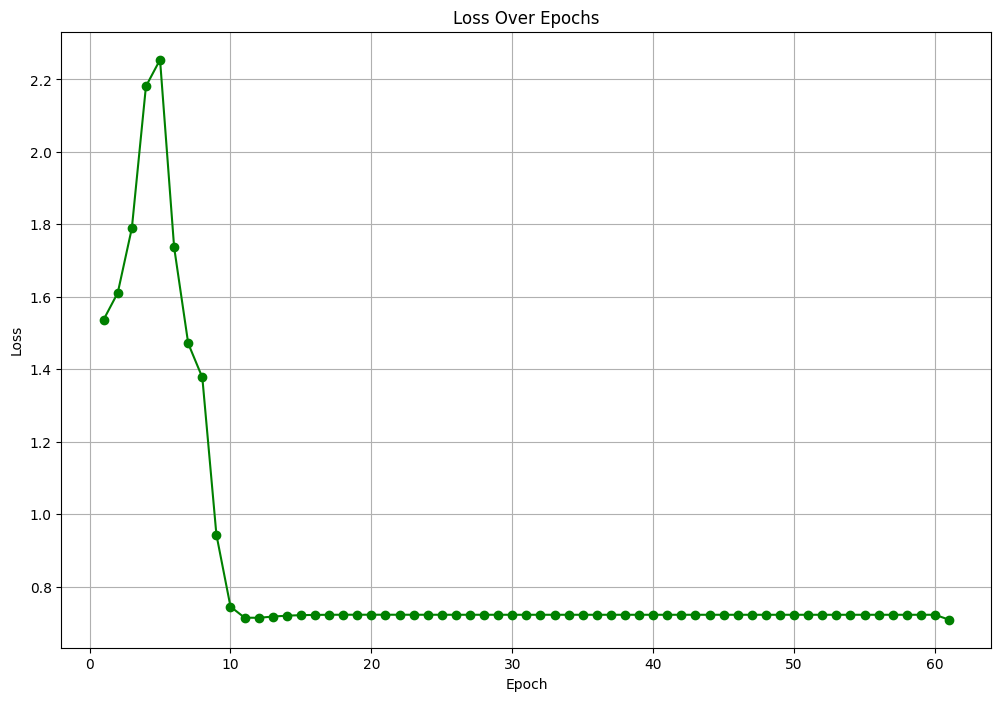

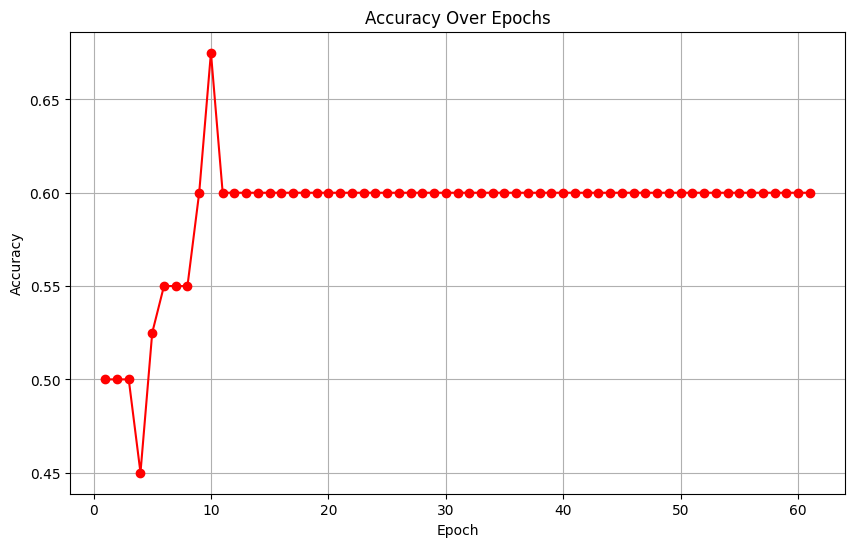

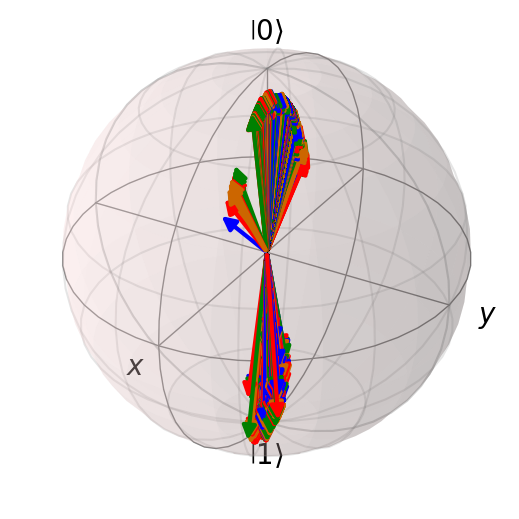

In [398]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *




plt.figure(figsize=(12, 8))
plt.plot(range(1, num_epochs + 2), losses, marker='o', linestyle='-', color='g')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+2), accuracies, marker='o', linestyle='-', color='r')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


def visualize_bloch(states):
    bloch_sphere = Bloch()

    for state in states:
        # Iterate over each qubit in the state
        for qubit_state in state:
            # Compute Bloch sphere coordinates for each qubit state
            x = 2 * np.real(np.dot(qubit_state.conj().T, np.array([[0, 1], [1, 0]]) @ qubit_state))
            y = 2 * np.imag(np.dot(qubit_state.conj().T, np.array([[0, -1j], [1j, 0]]) @ qubit_state))
            z = 2 * np.real(np.dot(qubit_state.conj().T, np.array([[1, 0], [0, -1]]) @ qubit_state)) - 1

            bloch_sphere.add_vectors([x, y, z])
    
    bloch_sphere.show()
    



# Convert final_states to numpy array if needed
final_states = np.array(final_states)

# Visualize the final states on the Bloch sphere
visualize_bloch(incorrectly_predicted_states)



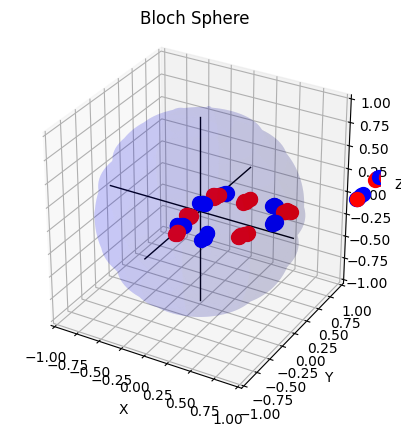

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the Bloch sphere coordinates
theta = np.linspace(0, np.pi, 100)
phi = np.linspace(0, 2*np.pi, 100)
theta, phi = np.meshgrid(theta, phi)

# Bloch sphere coordinates
x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])

# Plot the Bloch sphere
ax.plot_surface(x, y, z, color='b', alpha=0.1, rstride=10, cstride=10, linewidth=0)

# Plot the axes
ax.plot([-1, 1], [0, 0], [0, 0], color='k', lw=1)
ax.plot([0, 0], [-1, 1], [0, 0], color='k', lw=1)
ax.plot([0, 0], [0, 0], [-1, 1], color='k', lw=1)

finals_A=circuit(angles_A, parameters)
finals_B=circuit(angles_B, parameters)


for state in finals_A:  # Assuming finalsA contains the qubit states
    for q in state:
        alpha, beta = q  # Unpack real and imaginary parts
        x_qubit = 2 * alpha
        y_qubit = 2 * beta
        z_qubit = np.abs(alpha)**2 - np.abs(beta)**2
        ax.scatter(x_qubit, y_qubit, z_qubit, color='r', s=100)

for state in finals_B:  # Assuming finalsA contains the qubit states
    for q in state:
        alpha, beta = q  # Unpack real and imaginary parts
        x_qubit = 2 * alpha
        y_qubit = 2 * beta
        z_qubit = np.abs(alpha)**2 - np.abs(beta)**2
        ax.scatter(x_qubit, y_qubit, z_qubit, color='b', s=100)

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Set title
plt.title('Bloch Sphere')

# Show the plot
plt.show()
